# 소비자 데이터를 바탕으로 고객의 제품 총 소비량 예측

#### 필요 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
pd.set_option('mode.chained_assignment',  None)

## 1. 데이터 확인

In [2]:
# 데이터 불러온 후 확인
train = pd.read_csv('data/train.csv')
train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,8,7,0,0,0,0,0,0,0,541
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,7,1,1,0,0,0,0,0,0,899
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,9,3,0,0,0,0,0,0,0,901
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,3,8,0,0,0,0,0,0,0,50
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,5,7,0,0,0,1,0,0,0,444


#### 훈련 데이터 정보 확인

In [3]:
# 훈련 데이터 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   object 
 3   Marital_Status       1108 non-null   object 
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Dt_Customer          1108 non-null   object 
 8   Recency              1108 non-null   int64  
 9   NumDealsPurchases    1108 non-null   int64  
 10  NumWebPurchases      1108 non-null   int64  
 11  NumCatalogPurchases  1108 non-null   int64  
 12  NumStorePurchases    1108 non-null   int64  
 13  NumWebVisitsMonth    1108 non-null   int64  
 14  AcceptedCmp3         1108 non-null   int64  
 15  AcceptedCmp4         1108 non-null   i

In [4]:
train.target.describe()

count    1108.000000
mean      617.121841
std       603.587972
min         6.000000
25%        70.750000
50%       412.000000
75%      1068.750000
max      2525.000000
Name: target, dtype: float64

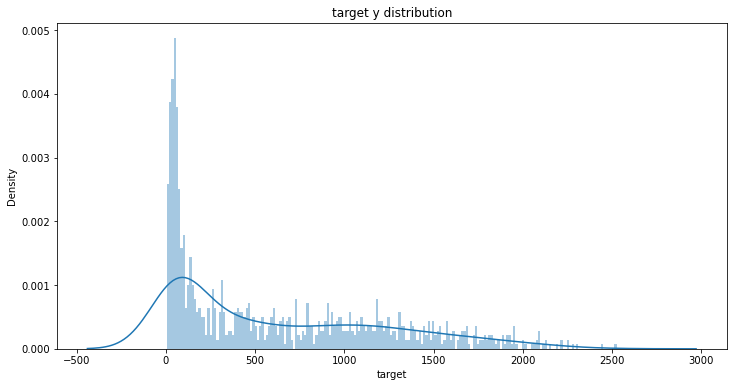

In [5]:
# 훈련 데이터셋의 타겟 분포도 확인
plt.figure(figsize=(12, 6))
sns.distplot(train.target, bins=200)
plt.title("target y distribution")
plt.show()

- Target 값의 분포 확인
- 대부분 100~500 사이에 분포하는 것을 알 수 있음.

## 2. 간단한 Preprocessing과 특성별 분석

#### 1) 각 특성별 데이터 탐색

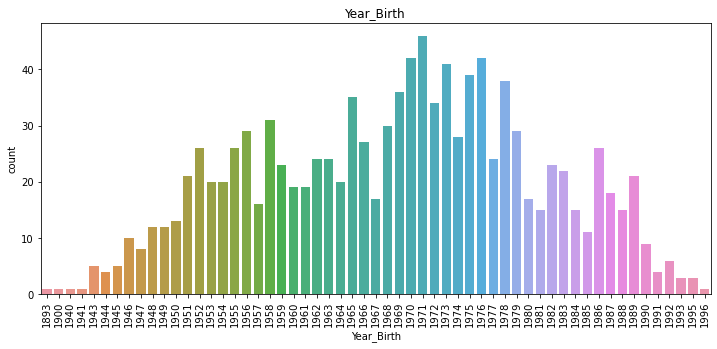

In [6]:
plt.figure(figsize=(12,5))
sns.countplot(x='Year_Birth',data=train)
plt.xticks(rotation=90);plt.title('Year_Birth')
plt.show()

- Year_Birth 값 확인
- 1893년, 1900년대 태어난 사람은 이상치로 간주 가능함

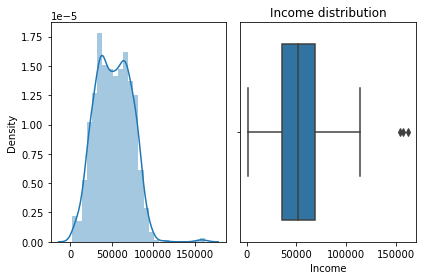

In [7]:
fig,ax = plt.subplots(1,2)
sns.distplot(x=train.Income, ax=ax[0]);
# plt.xticks(rotation=90);
plt.title('Income distribution')
sns.boxplot(x='Income',data=train, ax=ax[1])
plt.tight_layout()
plt.show()

- 소득 분포 확인
- 150,000 이상의 이상치가 존재하지만 상관관계가 높으므로 제거하지 않음

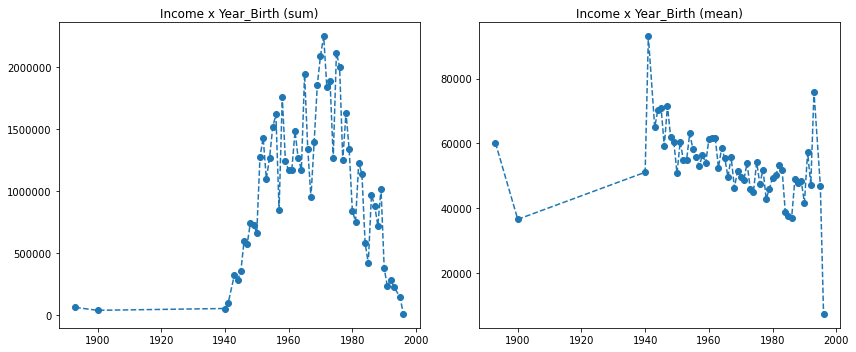

In [8]:
sample_sum = train[['Year_Birth','Income']].groupby('Year_Birth').sum()
sample_mean = train[['Year_Birth','Income']].groupby('Year_Birth').mean()

fig,ax = plt.subplots(1,2); fig.set_size_inches(12,5)

ax[0].yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
ax[0].plot(sample_sum.index,sample_sum.Income,'o--');
ax[0].set_title('Income x Year_Birth (sum)')

ax[1].plot(sample_mean.index,sample_mean.Income,'o--');
ax[1].set_title('Income x Year_Birth (mean)')

plt.tight_layout()
plt.show()

- 연령대가 높을수록 소득의 평균이 높아짐
- 40년대생, 93년생에서 평균 이상의 수치 발견

#### 1) 결측치 확인

In [9]:
# 결측치 존재 여부 확인
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


In [10]:
# Dt_customer 열을 y,m,d로 분리
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.Dt_Customer:
        year_point, month_point, day_point = date.split('-') # - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
        
    return year, month, day

day, month, year = seperate_datetime(train)
    
train['year'] = year
train['month'] = month
train['day'] = day

train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,0,0,0,0,0,0,541,2013,1,21
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,0,0,0,0,0,0,899,2014,5,24
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,0,0,0,0,0,0,901,2013,4,8
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,0,0,0,0,0,0,50,2014,3,29
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,0,0,1,0,0,0,444,2014,6,10


- 고객 가입일을 year, month, day로 분리
- year값이 target값과 상관관계를 가짐

In [11]:
train = train.drop('Dt_Customer', axis = 1)
train.shape ## (행, 열)

(1108, 24)

- 전처리가 끝난 Dt_Customer 열 삭제

#### 2) 피쳐별 데이터 탐색을 위한 피쳐 타입 분리

In [12]:
# 범주형과 수치형으로 분리함
categorical = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 
               'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 
               'Complain', 'Response']

quantitative = ['Year_Birth', 'Income', 'year',	'month', 'day', 'Recency', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

print('카테고리형(정성적) columns : {0} 개'.format(len(categorical)))
print('수치형(정량적) columns : {0} 개'.format(len(quantitative)))

카테고리형(정성적) columns : 11 개
수치형(정량적) columns : 11 개


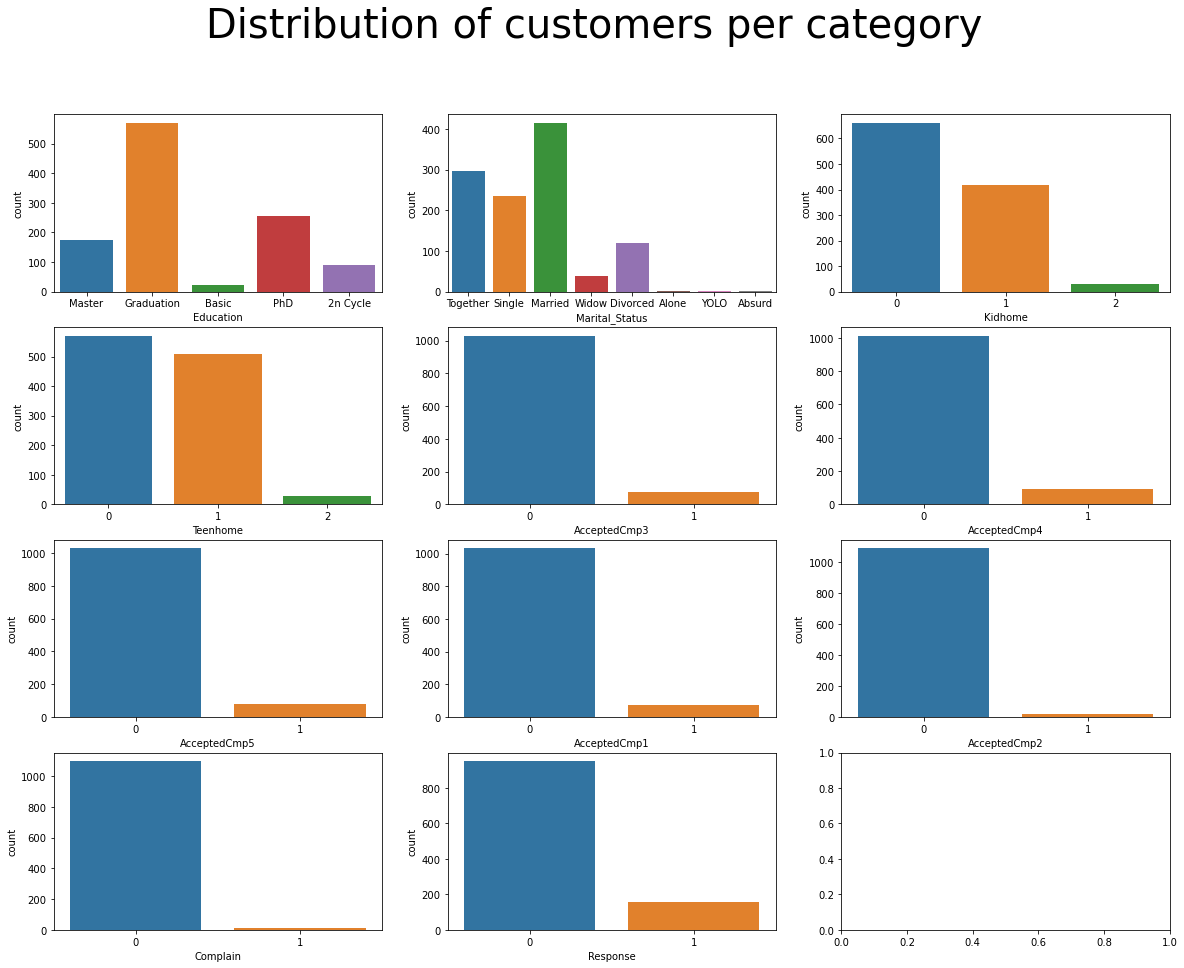

In [13]:
fig, axes = plt.subplots(4, 3, figsize=(20,15))
fig.suptitle('Distribution of customers per category', fontsize=40)

for ax, feature in zip(axes.flatten(), categorical):
    sns.countplot(data = train, x = feature, ax=ax)
plt.show()

- 범주형 데이터 탐색
- 각 범주의 빈도를 확인할 수 있음.
- 빈도가 낮은 항목의 경우 다른 항목과 합칠 수 있는지 연구

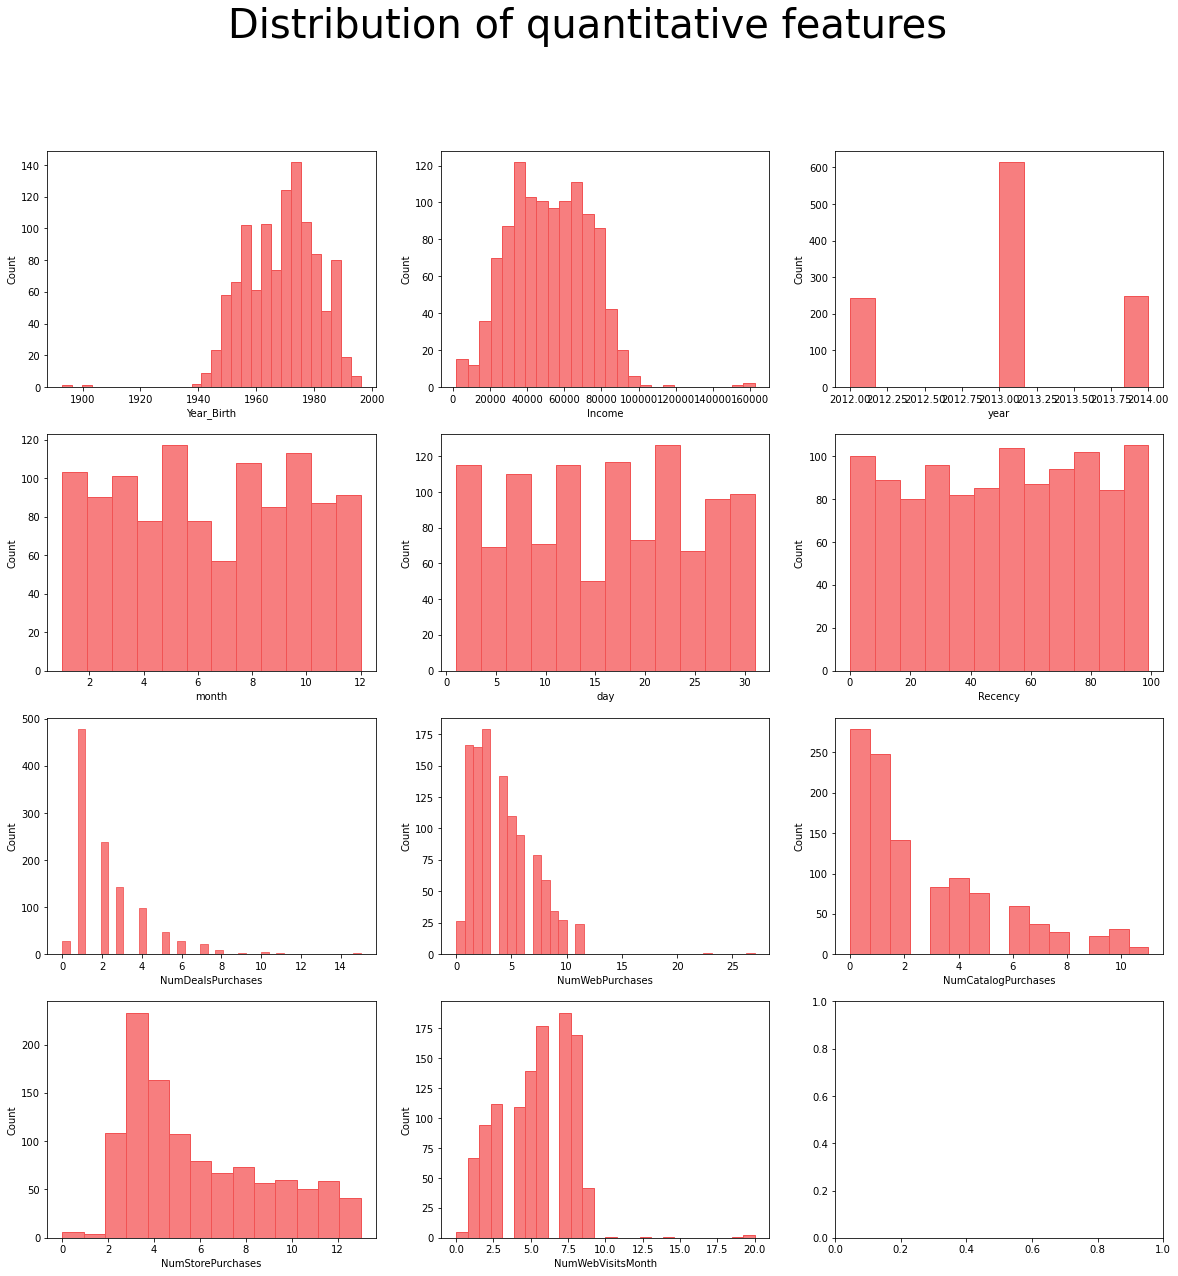

In [14]:
fig, axes = plt.subplots(4, 3, figsize=(20,20))
fig.suptitle('Distribution of quantitative features', fontsize=40)
#plt.tight_layout()

for ax,feature in zip(axes.flatten(),quantitative):
    sns.histplot(data = train, x = feature, ax=ax, color='#f55354', edgecolor='#f15354')
plt.show()

- 히스토그램을 사용한 수치형 데이터 탐색
- 몇개의 특성에서 이상치를 발견할 수 있음

#### 3) 이상치 탐색 ( IQR 사용)

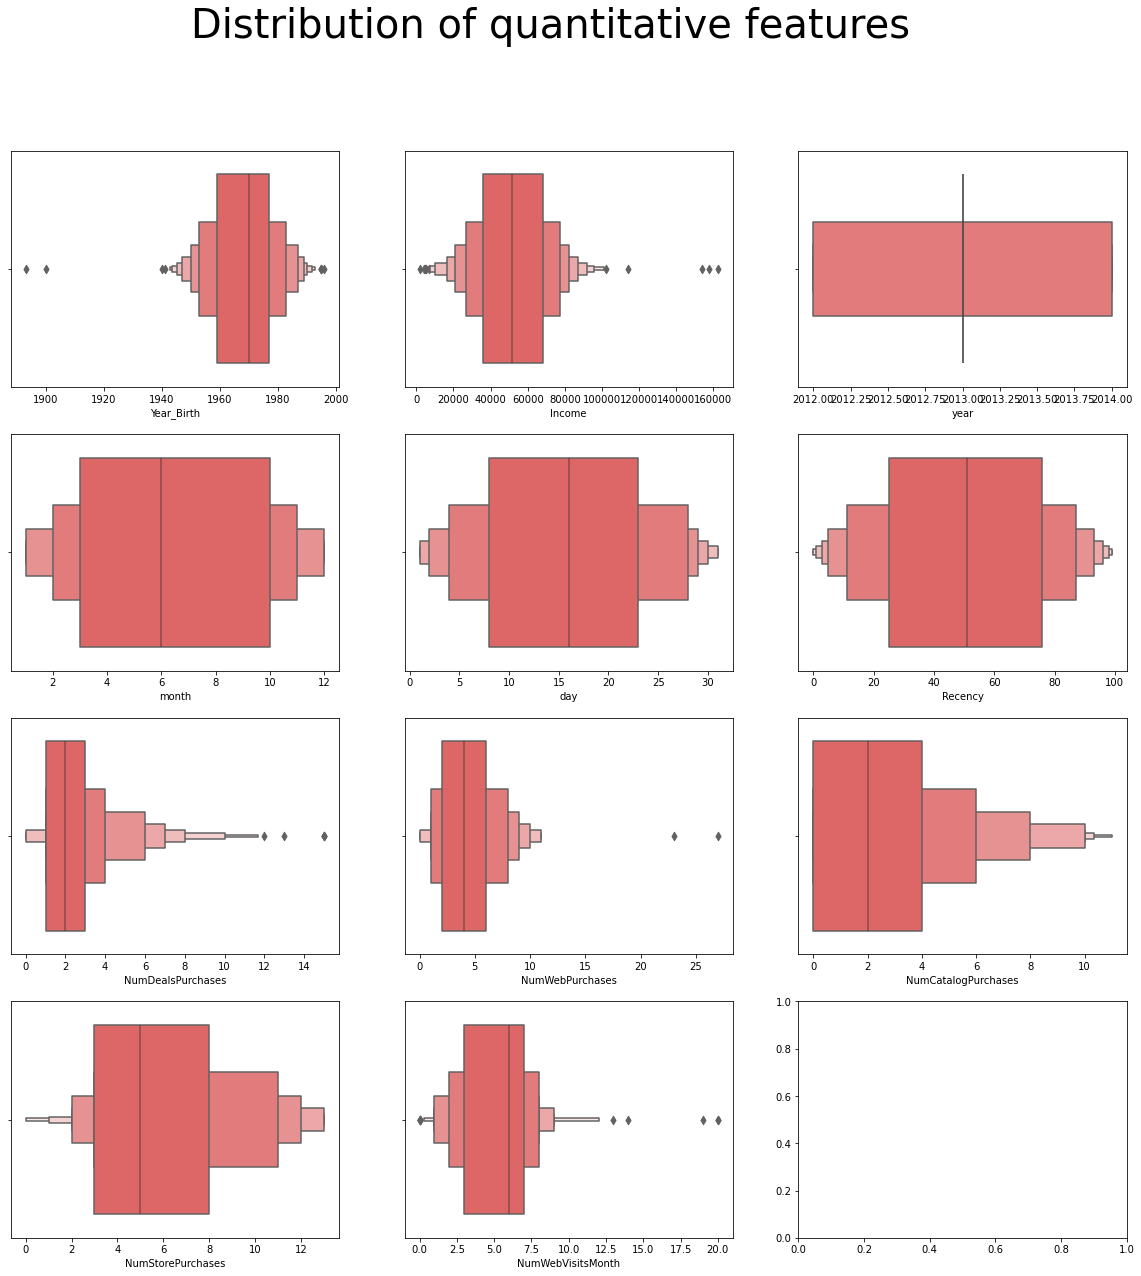

In [15]:
fig, axes = plt.subplots(4, 3, figsize=(20,20))
fig.suptitle('Distribution of quantitative features', fontsize=40)
#plt.tight_layout()

for ax,feature in zip(axes.flatten(),quantitative):
    sns.boxenplot(data = train, x = feature, ax=ax, color='#f15354')
plt.show()

- Income, NumDealsPurchases, NumWebPurchase, NumWebVisitsMonth 에서 이상치 발견
- 이상치라고 무조건 지우는 것이 X
- Income의 경우 target과의 상관관계가 높으므로 이상치 제거하지 않을 수 있음

In [16]:
from scipy import stats
def IQR(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 -(1.5 * IQR)
    upper_bound = Q3 +(1.5 * IQR)
    return lower_bound, upper_bound

outliers = train[quantitative].apply(lambda column: IQR(column))
print('Range of outliers by method')
outliers

Range of outliers by method


,Year_Birth,Income,year,month,day,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,1932.0,-13066.25,2013.0,-7.5,-14.5,-51.5,-2.0,-4.0,-6.0,-4.5,-3.0
1,2004.0,117159.75,2013.0,20.5,45.5,152.5,6.0,12.0,10.0,15.5,13.0


- IQR ( Interquartile range ): 사분위수 상위 75% 지점의 값과 하위 25% 지점의 값의 차이
- (Q3 - Q1)

In [17]:
# 이상치를 가지는 행이 몇개인지 확인 가능
def IQRsum(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 -(1.5 * IQR)
    upper_bound = Q3 +(1.5 * IQR)
    return ((column < lower_bound) | (column > upper_bound)).sum()

outliers = train[quantitative].drop(['year', 'month', 'day'], axis = 1).apply(lambda column: IQRsum(column))
print('Number of outliers by method')
outliers

Number of outliers by method


Year_Birth              2
Income                  3
Recency                 0
NumDealsPurchases      46
NumWebPurchases         2
NumCatalogPurchases     9
NumStorePurchases       0
NumWebVisitsMonth       4
dtype: int64

In [18]:
# 이상치를 제거할 때 사용하는 함수
def remove_outlier(data, column):
    fraud_column_data = data[column]
    quan_25 = np.percentile(fraud_column_data.values, 25)
    quan_75 = np.percentile(fraud_column_data.values, 75)
    
    iqr = quan_75 - quan_25
    iqr = iqr * 1.5
    lowest = quan_25 - iqr
    highest = quan_75 + iqr
    outlier_idx = fraud_column_data[(fraud_column_data < lowest) | (fraud_column_data > highest)].index
    print(len(outlier_idx))
    data.drop(outlier_idx, axis = 0, inplace=True)
    return data

#### 4) 상관관계 확인 (피어슨 상관관계 분석법)

In [19]:
quantitative.append('target')

Text(0.5, 1.0, 'Correlation between features')

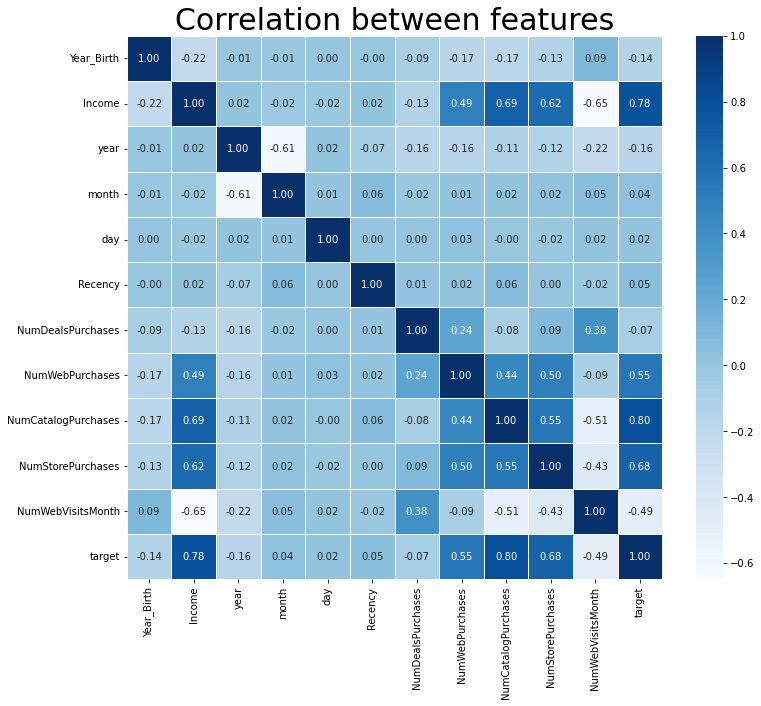

In [20]:
# 수치형 데이터 상관관계의 히트맵을 시각화
train_corr = train[quantitative]
scaler= MinMaxScaler()
train_corr[train_corr.columns] = scaler.fit_transform(train_corr[train_corr.columns])
corr28 = train_corr.corr(method= 'pearson')

plt.figure(figsize=(12,10))
sns.heatmap(data = corr28, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=30)

- Target과의 상관관계를 유의깊게 관찰
- Target과의 상관관계가 낮아도 다른 특성과의 상관관계가 높으면 남겨둘만 함

In [21]:
# Target과 피쳐들의 상관관계
s28 = corr28.unstack()
df_temp28 = pd.DataFrame(s28['target'].sort_values(ascending=False), columns=['target'])
df_temp28.style.background_gradient(cmap='viridis')

,target
target,1.000000
NumCatalogPurchases,0.798065
Income,0.784084
NumStorePurchases,0.677785
NumWebPurchases,0.546082
Recency,0.050873
month,0.037649
day,0.018917
NumDealsPurchases,-0.072802
Year_Birth,-0.136035
